# Expression Manipulation

In [1]:
from sympy import *
from sympy_equation import table_of_expressions
init_printing()

*Expression manipulation* indicates all the techniques that can be used in order to change the structure of a symbolic expression.

Think, for example, to collecting terms:

$$
a b + b = b (a + 1)
$$

This is the code to achieve it with SymPy:

In [2]:
a, b = symbols("a, b")
expr = a * b + b
expr.collect(b)

This was a simple procedure, because:

1. The expression is very easy.
2. The term to collect, $b$, is just a single symbol. So we only had to type a single character.

Now, imagine some complicated expression, in which we need to collect some complicated terms.
Hand-typing the terms to be collected might not be the best way to proceed, because:

1. we risk introducing typing errors. 
2. it takes time to type and double check the correctness of the terms.

Luckily for us, SymPy's symbolic expressions exposes the `find(pattern)` method, which can be used to extract sub-expressions matching the provided pattern.

**In this tutorial we are going to explore the limitations of `find(pattern)`, and introduce the `table_of_expressions` class exposed by this module which solves some of these limitations.**

## find and table_of_expressions

Let's consider this expression (which is reasonably simple in order to let the user understand the workflow that can be applied to much more convoluted expressions):

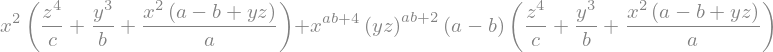

In [3]:
x, y, z, a, b, c = symbols("x:z a:c", real=True, positive=True)
expr = x**2 * (x**2 / a * (a - b + y*z) + y**3 / b + z**4 / c) + x**(a*b + 4) * (y * z)**(a*b + 2) * (a - b) * (x**2 / a * (a - b + y*z) + y**3 / b + z**4 / c)
expr

We would like to simplify it, so the first thing we can attempt is:

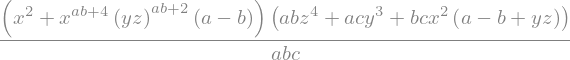

In [4]:
expr = expr.simplify()
expr

This is a pretty nice results, but there is one more thing that can be done. Under the assumption that all symbols are real and positive, bring out the $x^{2}$ term from the first addition. In order to do so, we have to perform this edit:

$$
x^{a b + 4} (y z)^{a b + 2} = x^{2} x^{a b + 2} (y z)^{a b + 2} = x^{2} (x y z)^{a b + 2}
$$

The first thing to do is to extract that specific term, using the `find` method:

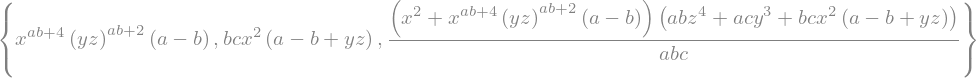

In [5]:
found = expr.find(lambda t: t.is_Mul and t.has(a - b))
found

Note that our interested term, $x^{a b + 4} (y z)^{a b + 2}$ is contained in this term: $x^{a b + 4} (y z)^{a b + 2} (a - b)$.

There are a few problems with this approach.

First, writing a more appropriate query is often time consuming. As a consequence, we will often get multiple matches.

Second, `found` is a set. The easiest way to retrive a particular element from a set is to convert it to a list, and index it. However, this process is non-deterministic:

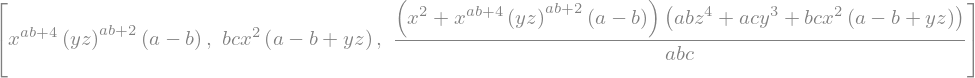

In [6]:
results = list(found)
results

In [7]:
interested_expr = results[0]
interested_expr

There is no guarantee that this code is reproducible. The next time the user will restart the kernel and execute the above cells, it is very likely that `interested_expr` shows a different expression, which would compute wrong results in the next cells of the notebook. In order to solve this problem, the conversion from a set to list must be deterministic. One way to achieve it is by sorting the results with an appropriate key, for example, the number of operations of an expression and its string representation:

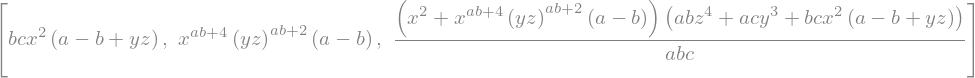

In [8]:
results = sorted(found, key=lambda expression: (count_ops(expression), str(expr)))
results

The third problem with this approach is that we need to count the index of the interested element in the list. With this simple example, it is trivial: the element we are interested in is at index 1. But for more complicated expressions or queries, we will soon discover that visually findind the correct index is time consuming and prone to errors.

In [9]:
interested_expr = results[1]
interested_expr

The last problem is that we need to remember all these things every time we execute the `find` method.

Here enter the `table_of_expressions` class. Given the results of a `find` operation, it shows a nice deterministic table containing expressions sorted as above, with visible indices:

In [10]:
toe = table_of_expressions(found)

| idx | exprs |
|:-----:|:------|
| 0 | $b c x^{2} \left(a - b + y z\right)$ |
| 1 | $x^{a b + 4} \left(y z\right)^{a b + 2} \left(a - b\right)$ |
| 2 | $\frac{\left(x^{2} + x^{a b + 4} \left(y z\right)^{a b + 2} \left(a - b\right)\right) \left(a b z^{4} + a c y^{3} + b c x^{2} \left(a - b + y z\right)\right)}{a b c}$ |


We can think of `toe` as a list, from which we can extract an element by its index:

In [11]:
interested_expr = toe[1]
interested_expr

Now we can start the actual edit:

In [12]:
target = interested_expr / (a - b)
target

In [13]:
replace = (target / x**2).powsimp() * x**2
replace

We can quickly verify that this manipulation didn't introduce errors:

In [14]:
replace.equals(target)

True

Finally:

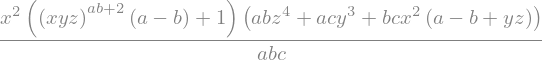

In [15]:
expr = expr.subs(target, replace).collect(x**2)
expr

**And that's about it for this tutorial.**

Before moving on, let's see what else `table_of_expressions` can do.

## table_of_expressions with `mode="args"`

If a symbolic expression is provided and `mode="args"` (default value), the table shows the arguments (or terms) that composes `expr` (as you would see when executing `expr.args`). They are not sorted! The fact that in this example they appear to be sorted is purely coincidental.

In [16]:
toe = table_of_expressions(expr, mode="args")

| idx | args |
|:-----:|:------|
| 0 | $\frac{1}{a}$ |
| 1 | $\frac{1}{b}$ |
| 2 | $\frac{1}{c}$ |
| 3 | $x^{2}$ |
| 4 | $\left(x y z\right)^{a b + 2} \left(a - b\right) + 1$ |
| 5 | $a b z^{4} + a c y^{3} + b c x^{2} \left(a - b + y z\right)$ |


In this mode of operation, it is guaranteed that:

In [17]:
toe[4] == expr.args[4]

True

In other words, using `toe[idx]` or `expr.args[idx]` will get the same expression.

With this mode of operation, if `expr` is a huge expression, then the table will be huge. We could filter the table to show only the elements that contains specific sub-expressions:

In [18]:
table_of_expressions(expr, select=[z**4, a*b])

| idx | args |
|:-----:|:------|
| 4 | $\left(x y z\right)^{a b + 2} \left(a - b\right) + 1$ |
| 5 | $a b z^{4} + a c y^{3} + b c x^{2} \left(a - b + y z\right)$ |


We will see in a different tutorial that this mode of operation is actually pretty useful.

## table_of_expressions with `mode="nodes"`

The other mode of operation is `mode="nodes"`, which shows an ordered list of unique nodes that makes up the expression tree. This is likely the least useful mode of operation, because for large expressions, it shows very large tables.

In [19]:
table_of_expressions(expr, mode="nodes")

| idx | nodes |
|:-----:|:------|
| 0 | $1$ |
| 1 | $2$ |
| 2 | $3$ |
| 3 | $4$ |
| 4 | $a$ |
| 5 | $b$ |
| 6 | $c$ |
| 7 | $x$ |
| 8 | $y$ |
| 9 | $z$ |
| 10 | $-1$ |
| 11 | $- b$ |
| 12 | $\frac{1}{a}$ |
| 13 | $\frac{1}{b}$ |
| 14 | $\frac{1}{c}$ |
| 15 | $a - b$ |
| 16 | $a b$ |
| 17 | $x^{2}$ |
| 18 | $y^{3}$ |
| 19 | $y z$ |
| 20 | $z^{4}$ |
| 21 | $a b + 2$ |
| 22 | $x y z$ |
| 23 | $a - b + y z$ |
| 24 | $a b z^{4}$ |
| 25 | $a c y^{3}$ |
| 26 | $\left(x y z\right)^{a b + 2}$ |
| 27 | $\left(x y z\right)^{a b + 2} \left(a - b\right)$ |
| 28 | $b c x^{2} \left(a - b + y z\right)$ |
| 29 | $\left(x y z\right)^{a b + 2} \left(a - b\right) + 1$ |
| 30 | $a b z^{4} + a c y^{3} + b c x^{2} \left(a - b + y z\right)$ |
| 31 | $\frac{x^{2} \left(\left(x y z\right)^{a b + 2} \left(a - b\right) + 1\right) \left(a b z^{4} + a c y^{3} + b c x^{2} \left(a - b + y z\right)\right)}{a b c}$ |


However, it is possible to filter the table in order to show elements that contains certain expressions:

In [20]:
table_of_expressions(expr, mode="nodes", select=[a - b])

| idx | nodes |
|:-----:|:------|
| 15 | $a - b$ |
| 23 | $a - b + y z$ |
| 27 | $\left(x y z\right)^{a b + 2} \left(a - b\right)$ |
| 28 | $b c x^{2} \left(a - b + y z\right)$ |
| 29 | $\left(x y z\right)^{a b + 2} \left(a - b\right) + 1$ |
| 30 | $a b z^{4} + a c y^{3} + b c x^{2} \left(a - b + y z\right)$ |
| 31 | $\frac{x^{2} \left(\left(x y z\right)^{a b + 2} \left(a - b\right) + 1\right) \left(a b z^{4} + a c y^{3} + b c x^{2} \left(a - b + y z\right)\right)}{a b c}$ |
